## Imports and Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 


import librosa
from librosa import display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
sr = 22050
Y_LIMIT = 660000

In [3]:
class DataLoader():
    def __init__(self, seg=5):
        '''
        Initializes the DataLoader.
        
        Forces deteriminism by setting np.seed=1.
        
        self.SEG is the number of fixed-length segments, and the number of random crops to take
        self.SEG_LENGTH is the length of each fixed-length segment
        self.RANDOM_SEG_LENGTH is the length of each random crop
        
        self.train_idxs is a list of 750 training indices
        self.test_idxs is a list of 250 testing indices
        
        self.train_crop_idxs is a list of 750*self.SEG training indices, corresponding to the same indices above
        self.test_crop_idxs  is a list of 750*self.SEG testing indices,  corresponding to the same indices above
        
        eg. train_idxs      = [1, 2, 4, ...]
            train_crop_idxs = [10 ... 19, 20 ... 29, 40 ... 49, ...]
            
        Cropped X's retain the order of the uncropped X's
        i.e. the first 10 self.mfcc_fixed_crop entries correspond to the first self.mfcc entry.
        '''
        np.random.seed(1)
        self.X_mfcc = None
        self.X_mfcc_random_crop = None
        self.X_mfcc_fixed_crop = None
        
        self.X_chroma = None
        self.X_chroma_random_crop = None
        self.X_chroma_fixed_crop = None
        
        self.Y = None
        self.Y_crop = None
        
        self.SEG = seg   # Must evenly divide 30
        self.SEG_LENGTH = int(1290/self.SEG)
        self.RANDOM_SEG_LENGTH = 1200
        self.PAD = 1290 - self.RANDOM_SEG_LENGTH
        self.RANDOM_STARTS = np.random.randint(low=0, high=1290-self.RANDOM_SEG_LENGTH, size=(1000, self.SEG))
        
        self.train_idxs = np.sort(np.random.choice(np.array([i for i in range(1000)]), size=500, replace=False))
        self.val_idxs = np.sort(np.random.choice(np.array([i for i in range(1000) if i not in self.train_idxs]), size=250, replace=False))
        self.test_idxs = np.array([i for i in range(1000) if i not in self.train_idxs and i not in self.val_idxs])

        self.train_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.train_idxs])
        self.val_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.val_idxs])
        self.test_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.test_idxs])

    def save_mfcc(self, genres=all_genres, songs=num_songs):
        '''
        Saves MFCC Coefficients.
        Produces a 1000 x 16770 array.
        '''
        assert(self.X_mfcc is None)
        X_mfcc = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
                y = y[:Y_LIMIT]
                mfcc = librosa.feature.mfcc(y, sr=sr, hop_length=512, n_mfcc=13).flatten()
                if X_mfcc is None:
                    X_mfcc = mfcc.reshape(1, mfcc.shape[0])
                else:
                    X_mfcc = np.vstack([X_mfcc, mfcc])
        scaler = StandardScaler()
        self.X_mfcc = scaler.fit_transform(X_mfcc)
        np.savetxt('data/X_mfcc.csv', self.X_mfcc)
    
    def save_mfcc_random_crop(self):
        '''
        Saves self.SEG random crops of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 1200 array, padded with zeros to 10000 x 13 x 1290.
        Reshapes into 10000*16770 for the CSV.
        '''
        assert(self.X_mfcc_random_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for i, mfcc in enumerate(self.X_mfcc):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([mfcc[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(13)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_random_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_random_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*1290))
    
    def save_mfcc_fixed_crop(self):
        '''
        Saves self.SEG even segments of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1677 for the CSV.
        '''
        assert(self.X_mfcc_fixed_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for mfcc in self.X_mfcc:
            crop = np.stack([np.vstack([mfcc[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(13)]) for i in range(self.SEG)], axis=0)
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_fixed_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*self.SEG_LENGTH))
    
    def save_chroma(self, genres=all_genres, songs=num_songs):
        '''
        Saves Chromas.
        Produces a 1000 x 15480 array.
        '''
        assert(self.X_chroma is None)
        X_chroma = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
                y = y[:Y_LIMIT]
                chroma = librosa.feature.chroma_cqt(y, sr=sr, hop_length=512).flatten()
                if X_chroma is None:
                    X_chroma = chroma.reshape(1, chroma.shape[0])
                else:
                    X_chroma = np.vstack([X_chroma, chroma])
        scaler = StandardScaler()
        self.X_chroma = scaler.fit_transform(X_chroma)
        np.savetxt('data/X_chroma.csv', self.X_chroma)

    def save_chroma_random_crop(self):
        '''
        Saves 10 random crops of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 1200 array, padded with zeros to 10000 x 12 x 1290.
        Reshapes into 10000*15480 for the CSV.
        '''
        assert(self.X_chroma_random_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for i, chroma in enumerate(self.X_chroma):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([chroma[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(12)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_random_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_random_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*1290))
        
    def save_chroma_fixed_crop(self):
        '''
        Saves 10 even segments of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1548 for the CSV.
        '''
        assert(self.X_chroma_fixed_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for chroma in self.X_chroma:
            crop = np.stack([np.vstack([chroma[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(12)]) for i in range(self.SEG)], axis=0)
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_fixed_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*self.SEG_LENGTH))
    
    '''
    If X_mfcc has been saved, but we aborted before saving X_mfcc_random_crop (or X_mfcc_fixed_crop), 
    we can call load_mfcc with tensor=False to load the MFCC in 2D and then call dl.save_random_crop().
    Note that all load functions reshape into tensors by default.
    '''  
    
    def load_mfcc(self, tensor=True):
        self.X_mfcc = np.loadtxt('data/X_mfcc.csv')
        if tensor:
            self.X_mfcc = self.X_mfcc.reshape(1000, 13, 1290)
    
    def load_mfcc_random_crop(self):
        self.X_mfcc_random_crop = np.loadtxt(f'data/X_mfcc_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, 1290)
        
    def load_mfcc_fixed_crop(self):
        self.X_mfcc_fixed_crop = np.loadtxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, self.SEG_LENGTH)
        
    def load_chroma(self, tensor=True):
        self.X_chroma = np.loadtxt('data/X_chroma.csv')
        if tensor:
            self.X_chroma = self.X_chroma.reshape(1000, 12, 1290)
    
    def load_chroma_random_crop(self):
        self.X_chroma_random_crop = np.loadtxt(f'data/X_chroma_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, 1290)
        
    def load_chroma_fixed_crop(self):
        self.X_chroma_fixed_crop = np.loadtxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, self.SEG_LENGTH)
    
    def load_Y(self):
        self.Y = np.array([int(i/100) for i in range(1000)]).ravel()
        
    def load_Y_crop(self):
        self.Y_crop = np.array([int(i/(100 * self.SEG)) for i in range(1000 * self.SEG)]).ravel()
        
    def train_test_val_split(self, data, is_cropped):
        '''
        Splits an X_data into train, validation, and test sets.
        
        is_cropped=True for splitting random or fixed crops, iscropped=False for splitting original mfcc/chroma
        
        Train, val, and test indices are consistent every time train_test_split is called.
        
        Furthermore, cropped train and test indices are returned so that batches of size self.SEG are together, 
        with each batch corresponding to a single non-cropped index.
        '''
        if is_cropped:
            return np.take(data, self.train_crop_idxs, 0), np.take(data, self.val_crop_idxs, 0), np.take(data, self.test_crop_idxs, 0)
        else:
            return np.take(data, self.train_idxs, 0), np.take(data, self.val_idxs, 0), np.take(data, self.test_idxs, 0)

In [4]:
%%time
dl = DataLoader(5)
dl.load_mfcc(tensor=False)
# dl.load_mfcc_fixed_crop()
# dl.load_mfcc_random_crop()
dl.load_chroma(tensor=False)
# dl.load_chroma_fixed_crop()
# dl.load_chroma_random_crop()
dl.load_Y()
# dl.load_Y_crop()

CPU times: user 28 s, sys: 1.11 s, total: 29.1 s
Wall time: 31.8 s


In [5]:
def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title}'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [6]:
def plot_labels_3d(data, labels, title, pca_X):
    pca = PCA(n_components=3, random_state=1)
    pca.fit(pca_X) # Matrix to PCA on
    projected = pca.transform(data)
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(title, fontsize=20) 
    ax = fig.add_subplot(111, projection='3d')
    for l, c in zip(range(0, 10),
                    ('blue', 'red', 'green', 'orange', 'yellow', 'black', 'purple', 'cyan', 'brown', 'pink')):
        ax.scatter(projected[labels == l, 0],
                    projected[labels == l, 1],
                    projected[labels == l, 2],
                    color=c,
                    label='%s' % all_genres[l],
                    alpha=.5,
                    marker='o',
                    s=60
                    )
    ax.set_xlabel('PCA dimension 1')
    ax.set_ylabel('PCA dimension 2')
    ax.set_zlabel('PCA dimension 3')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    

In [7]:
print('Train, validate, and test the vanilla model\n')

Xm_train, Xm_val, Xm_test = dl.train_test_val_split(dl.X_mfcc, is_cropped=False)
Xc_train, Xc_val, Xc_test = dl.train_test_val_split(dl.X_chroma, is_cropped=False)

X_train = np.concatenate([Xm_train, Xc_train], axis=1)
X_val = np.concatenate([Xm_val, Xc_val], axis=1)
X_test = np.concatenate([Xm_test, Xc_test], axis=1)

Y_train, Y_val, Y_test = dl.train_test_val_split(dl.Y, is_cropped=False)

print(f'Train size:    {X_train.shape}', f'     Train labels size: {Y_train.shape}')
print(f'Val size:      {X_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:     {X_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train, validate, and test the vanilla model

Train size:    (500, 32250)      Train labels size: (500,)
Val size:      (250, 32250)      Val labels size:   (250,)
Test size:     (250, 32250)      Test labels size:  (250,)


## Vanilla Architectures

---------------------------CRNN-------------------------------
VALIDATION: 0.336, TEST:0.388


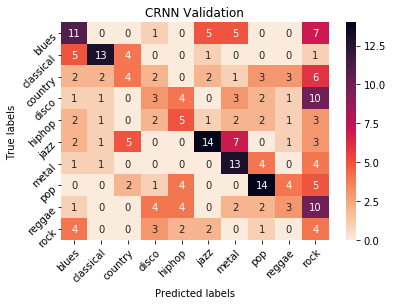

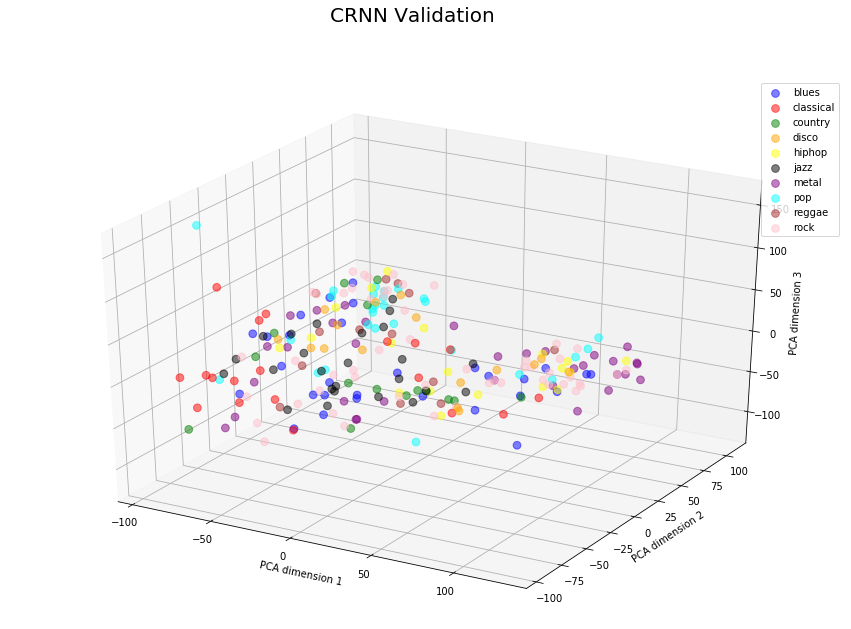

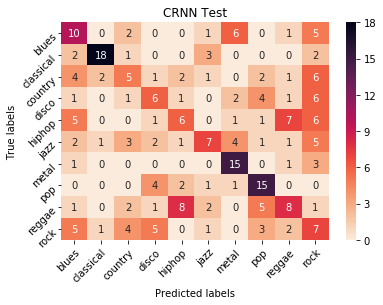

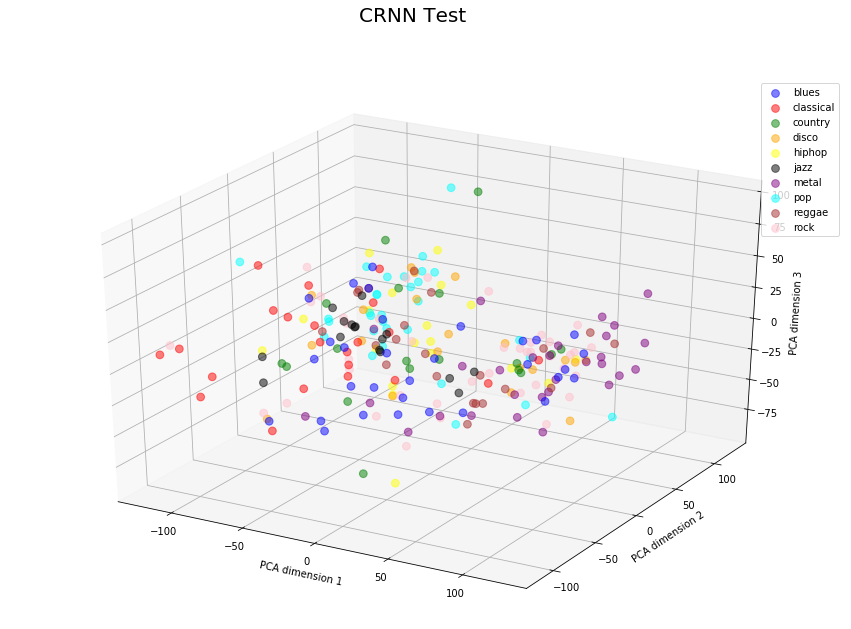

---------------------------SRNN-------------------------------
VALIDATION: 0.36, TEST:0.448


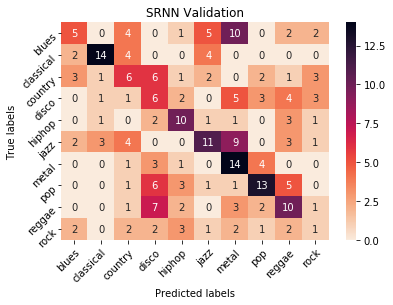

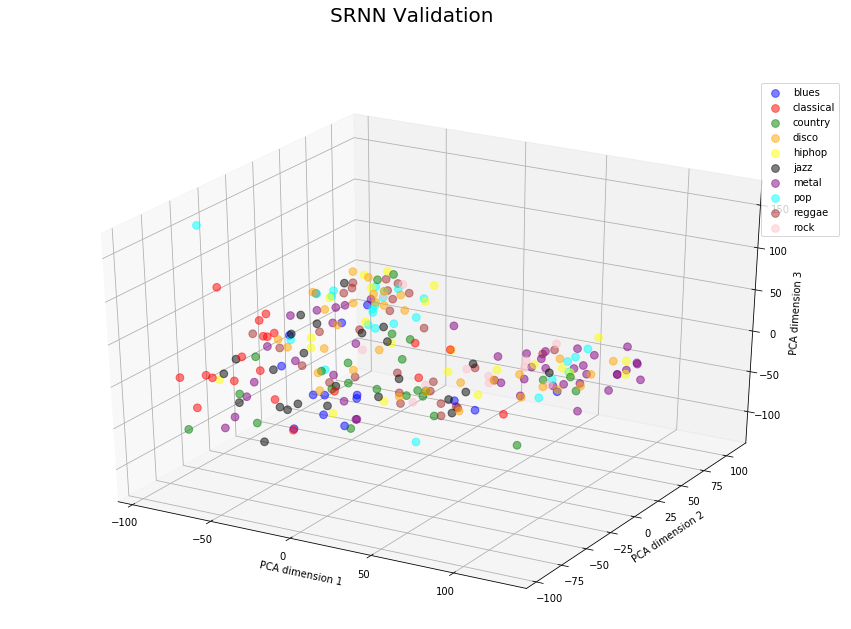

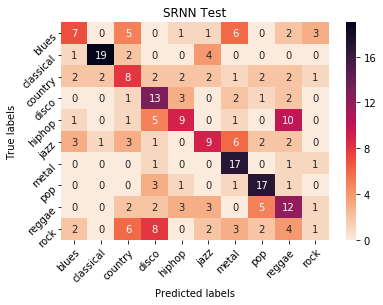

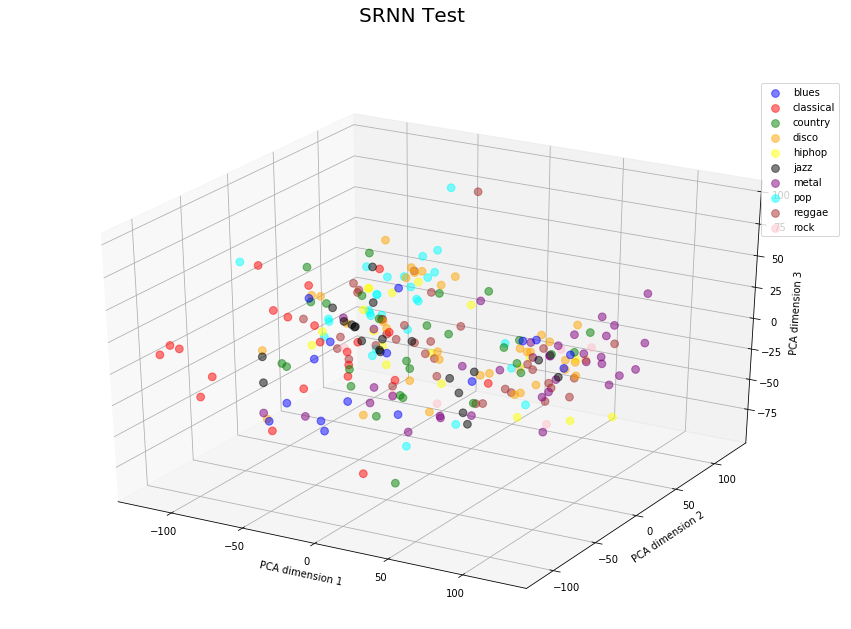

---------------------------DRNN-------------------------------
VALIDATION: 0.344, TEST:0.36


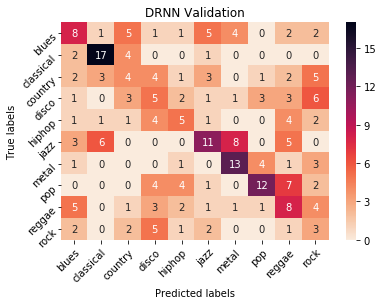

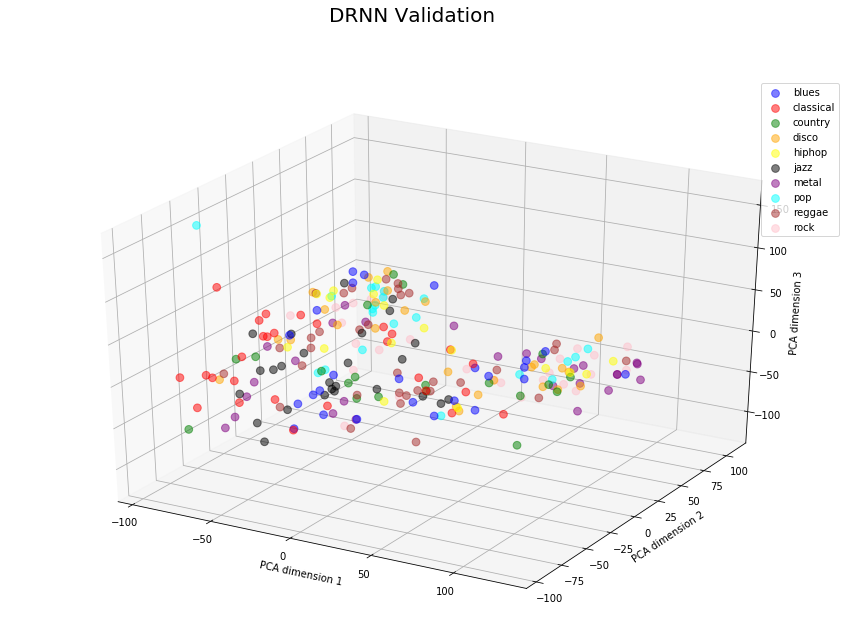

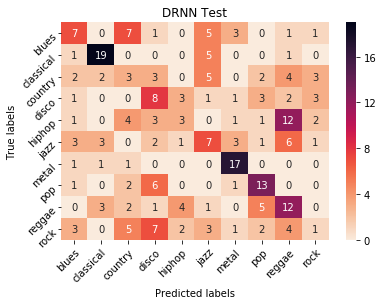

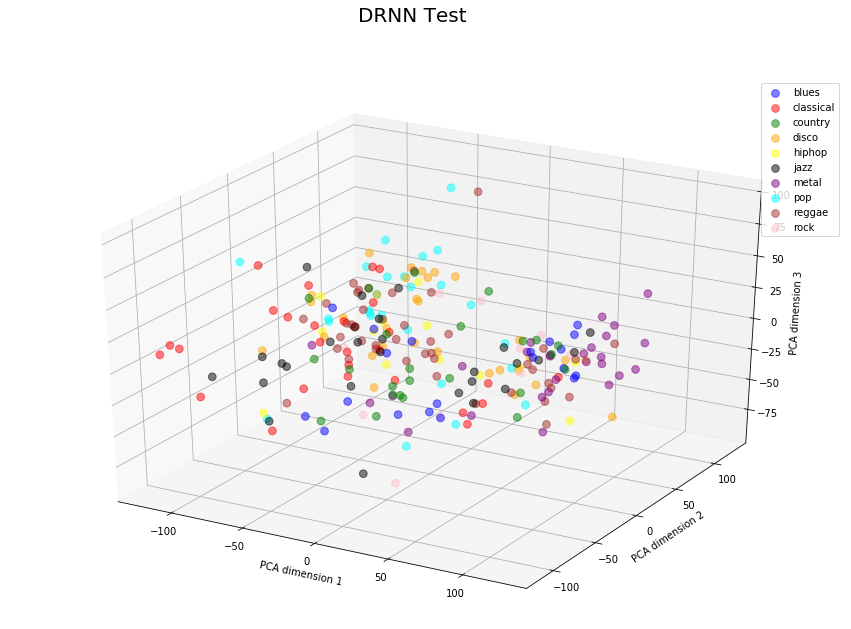

In [38]:
to_load = [
    ('nn/vanilla/val_predictions_vanilla_cr.npy', 'nn/vanilla/test_predictions_vanilla_cr.npy', 'CRNN'),
    ('nn/vanilla/val_predictions_vanilla_sfr.npy', 'nn/vanilla/test_predictions_vanilla_sfr.npy', 'SRNN'),
    ('nn/vanilla/val_predictions_vanilla_dfr.npy', 'nn/vanilla/test_predictions_vanilla_dfr.npy', 'DRNN'),
]

for val_file, test_file, title in to_load:
    print(f'---------------------------{title}-------------------------------')
    
    val_pred = np.load(val_file)
    test_pred = np.load(test_file)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Fixed Crop

In [9]:
def vote(arr):
    unique, counts = np.unique(arr, return_counts=True)
    counts = dict(zip(unique, counts))
    counts = [(k, v) for k, v in counts.items()]
    counts.sort(key=lambda x : x[1], reverse=True)
    out = []
    max_occurrences = counts[0][1]
    for i in range(len(counts)):
        if counts[i][1] == max_occurrences:
            out.append(counts[i][0])
        else:
            break
    out_arr = np.array(out)
    np.random.seed(1)
    return np.random.choice(out, size=1)
    
def batchify(pred, seg):
    num_songs = int(pred.shape[0]/seg)
    return np.array([vote(pred[i*seg:(i+1)*seg]) for i in range(num_songs)]).ravel()

---------------------------Fixed Segments, k=1-------------------------------
VALIDATION: 0.352, TEST:0.44


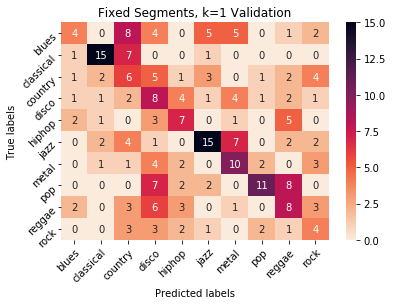

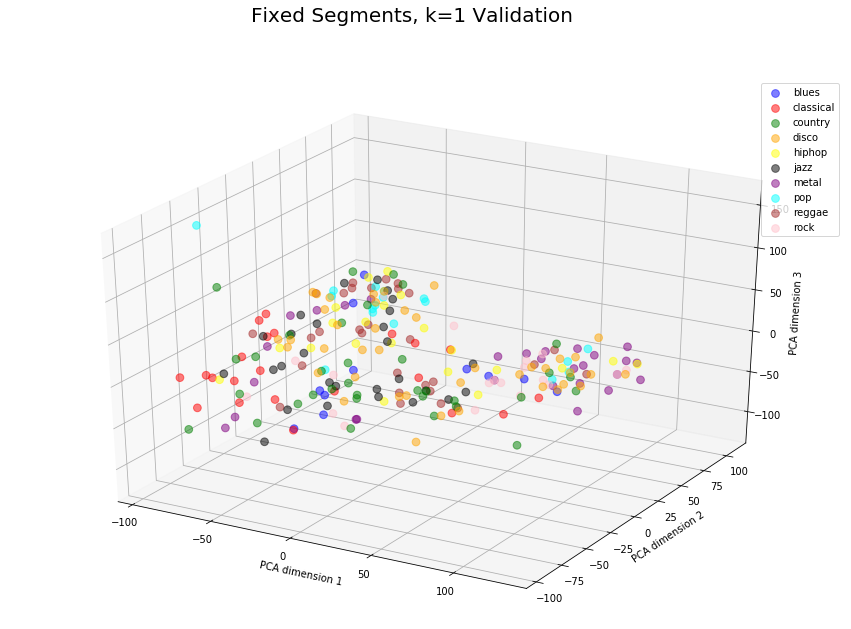

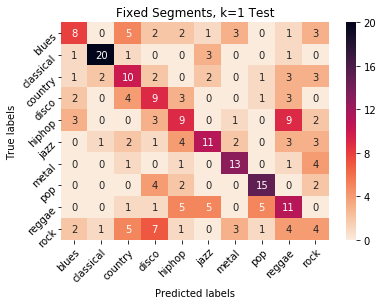

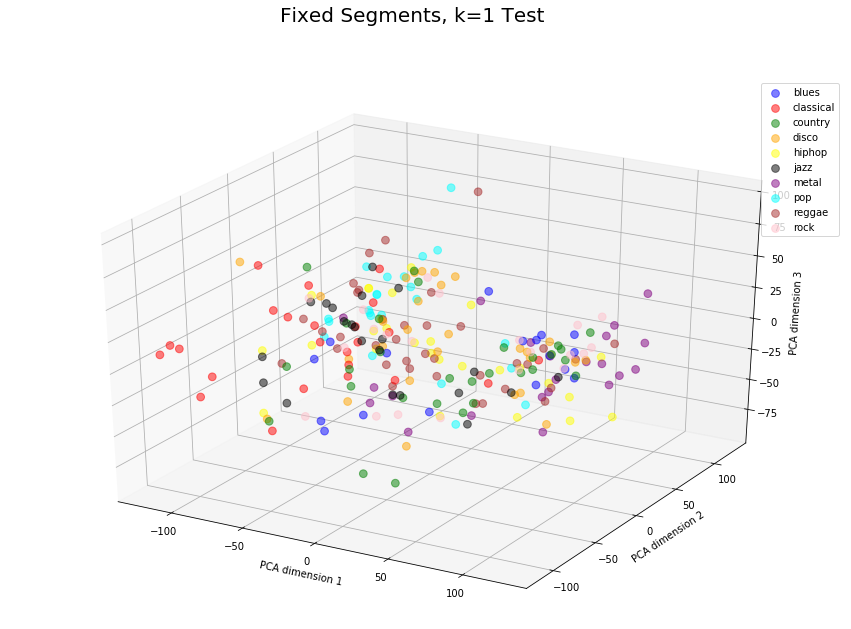

---------------------------Fixed Segments, k=2-------------------------------
VALIDATION: 0.368, TEST:0.452


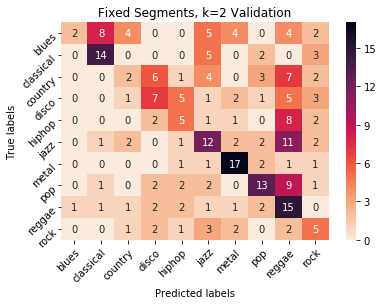

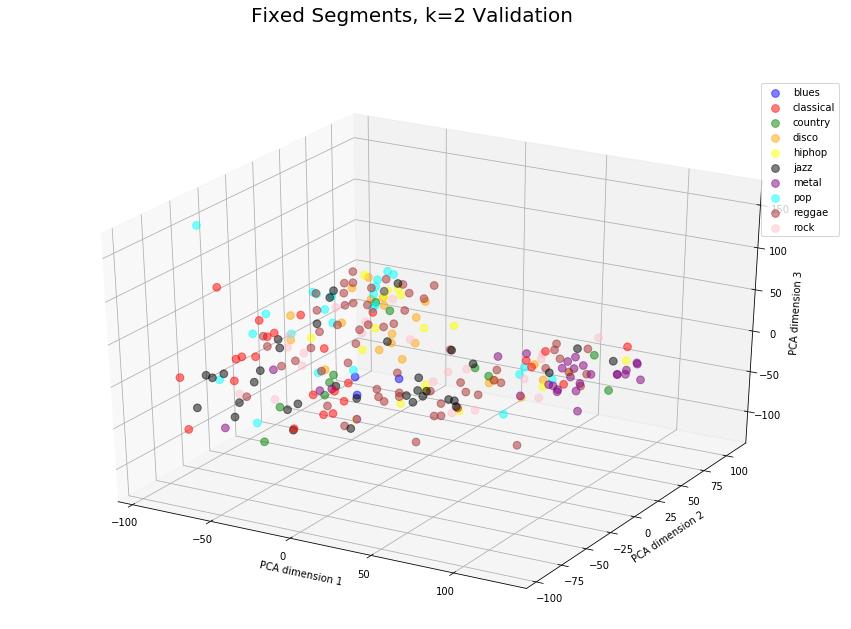

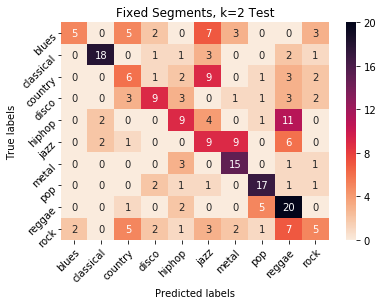

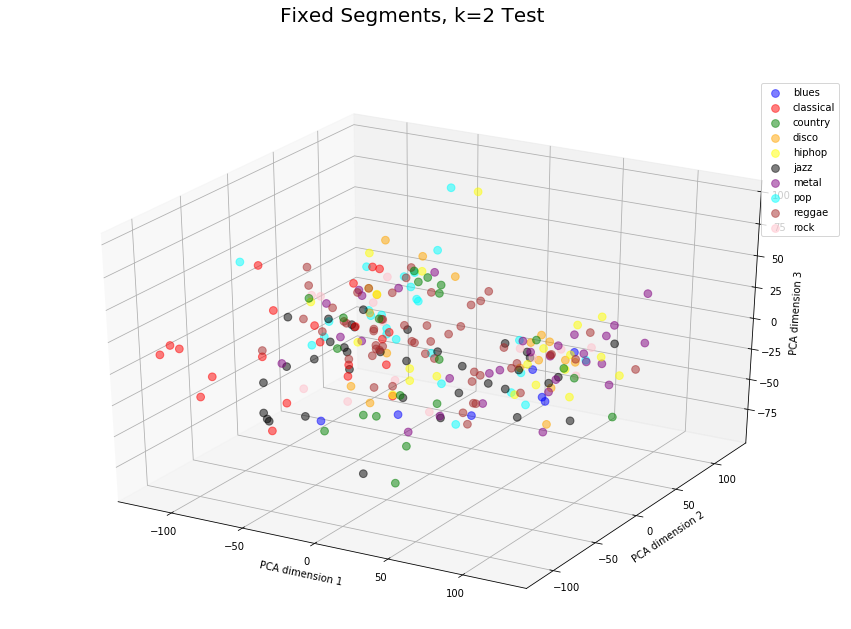

---------------------------Fixed Segments, k=5-------------------------------
VALIDATION: 0.636, TEST:0.648


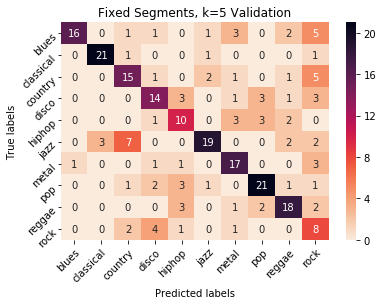

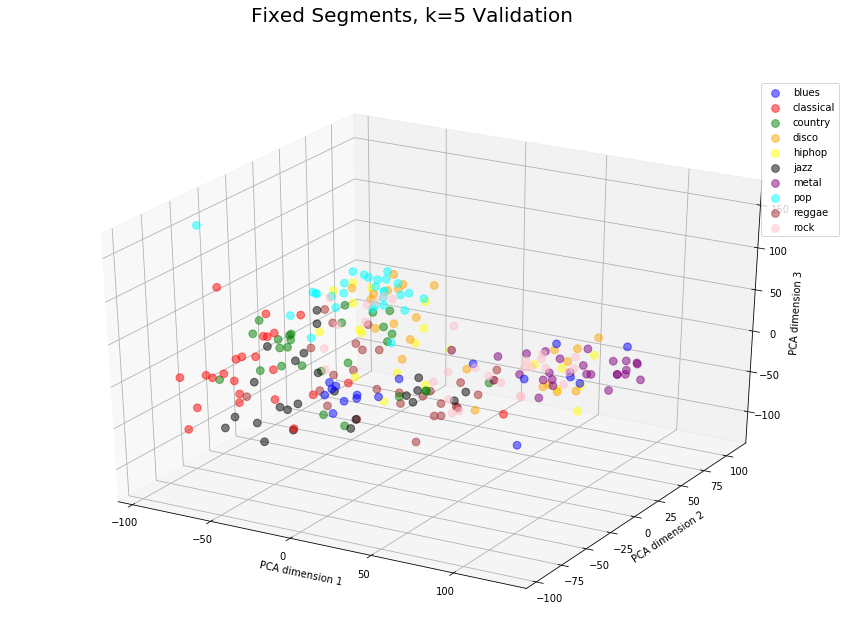

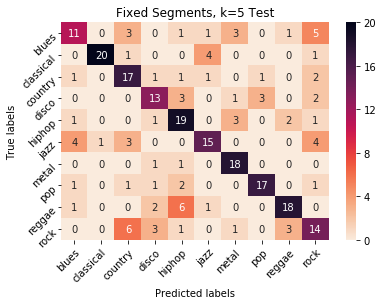

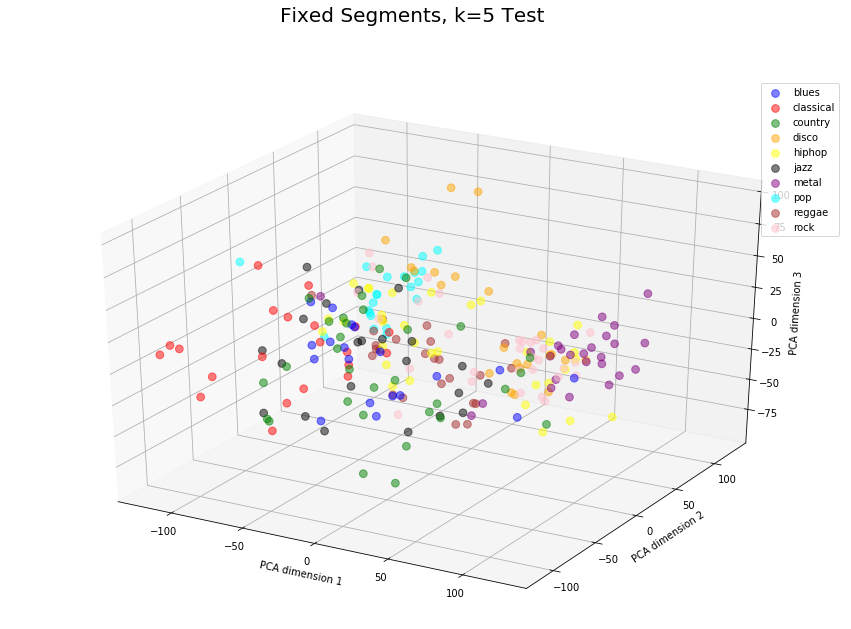

---------------------------Fixed Segments, k=10-------------------------------
VALIDATION: 0.52, TEST:0.668


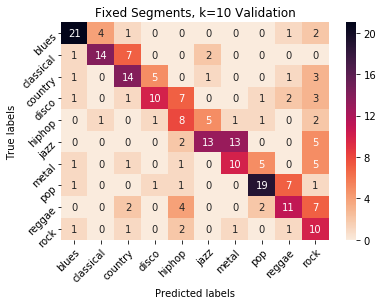

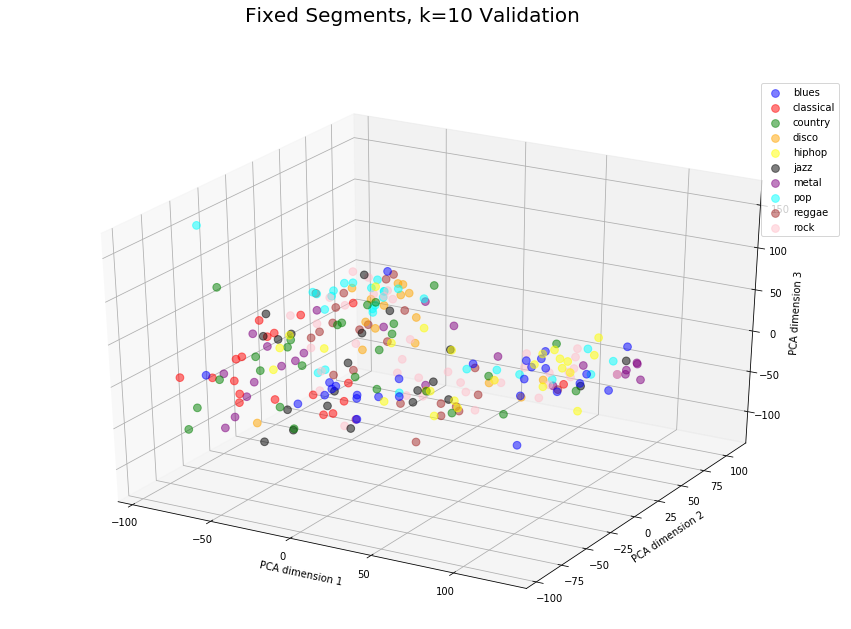

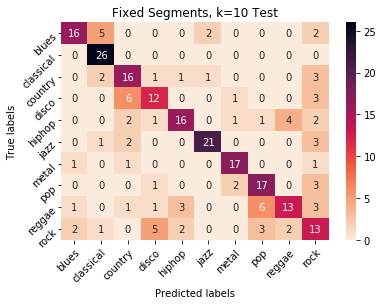

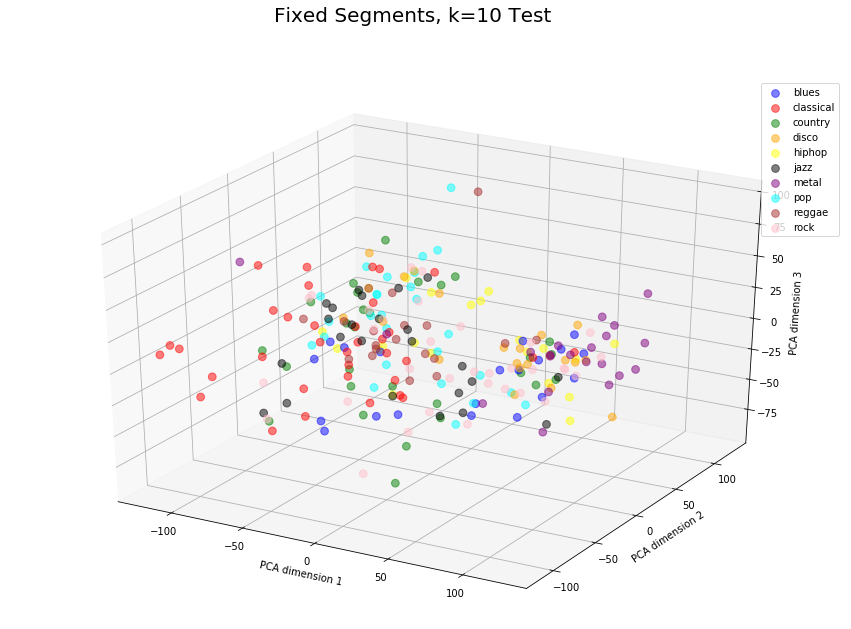

---------------------------Fixed Segments, k=30-------------------------------
VALIDATION: 0.644, TEST:0.58


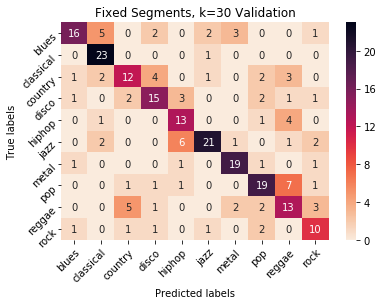

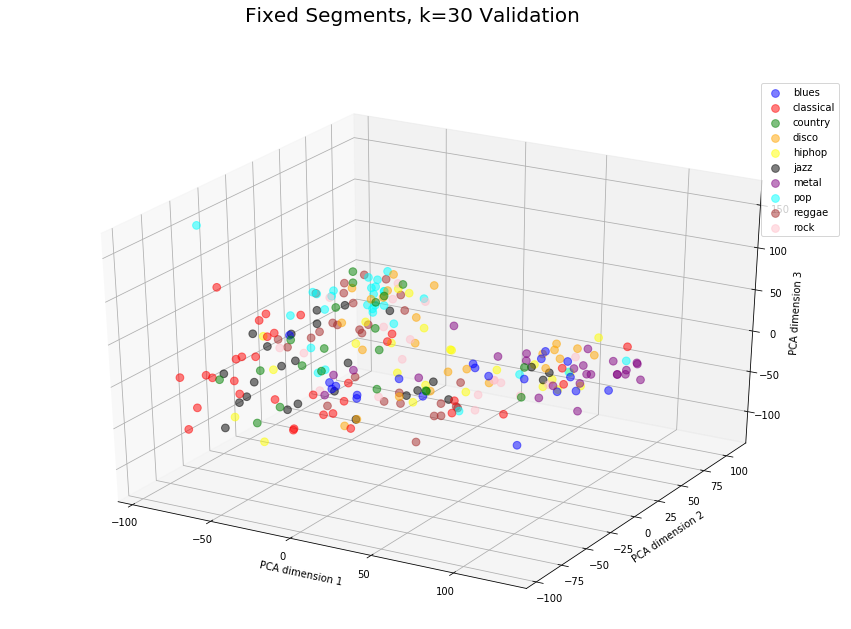

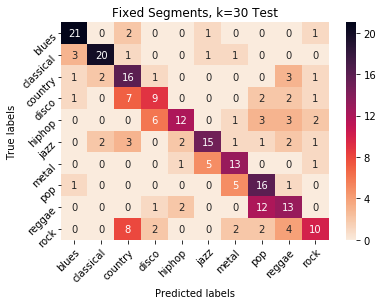

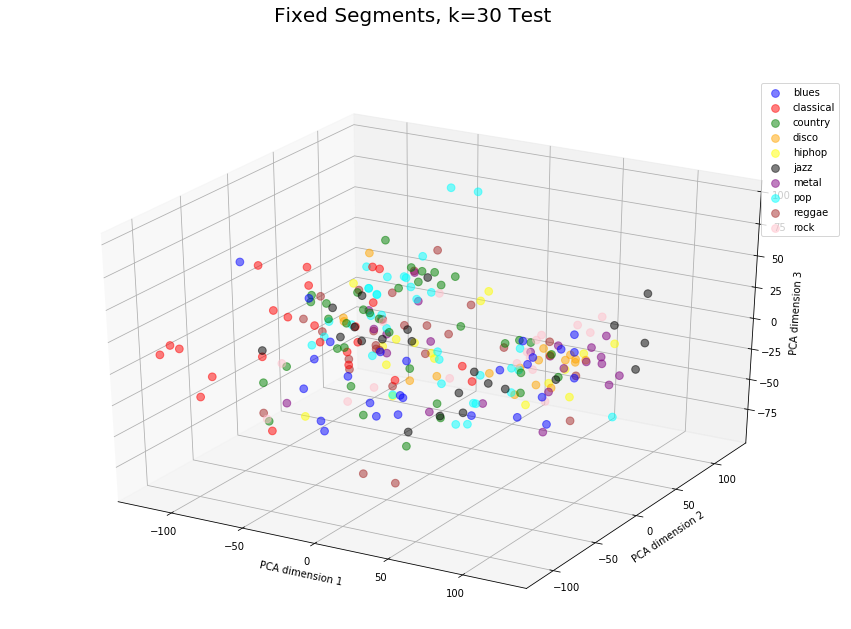

In [11]:
to_load = [
    (1, 'nn/fixed_crop/val_predictions_fixed_crop_1.npy', 'nn/fixed_crop/test_predictions_fixed_crop_1.npy', 'Fixed Segments, k=1'),
    (2, 'nn/fixed_crop/val_predictions_fixed_crop_2.npy', 'nn/fixed_crop/test_predictions_fixed_crop_2.npy', 'Fixed Segments, k=2'),
    (5, 'nn/fixed_crop/val_predictions_fixed_crop_5.npy', 'nn/fixed_crop/test_predictions_fixed_crop_5.npy', 'Fixed Segments, k=5'),
    (10, 'nn/fixed_crop/val_predictions_fixed_crop_10.npy', 'nn/fixed_crop/test_predictions_fixed_crop_10.npy', 'Fixed Segments, k=10'),
    (30, 'nn/fixed_crop/val_predictions_fixed_crop_30.npy', 'nn/fixed_crop/test_predictions_fixed_crop_30.npy', 'Fixed Segments, k=30'),
]

for k, val_file, test_file, title in to_load:
    print(f'---------------------------{title}-------------------------------')
    val_pred = batchify(np.load(val_file), k)
    test_pred = batchify(np.load(test_file), k)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Random Crop

---------------------------Random Crops, k=5-------------------------------
VALIDATION: 0.136, TEST:0.124


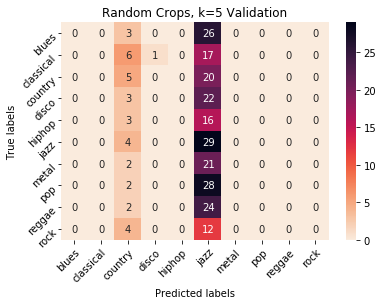

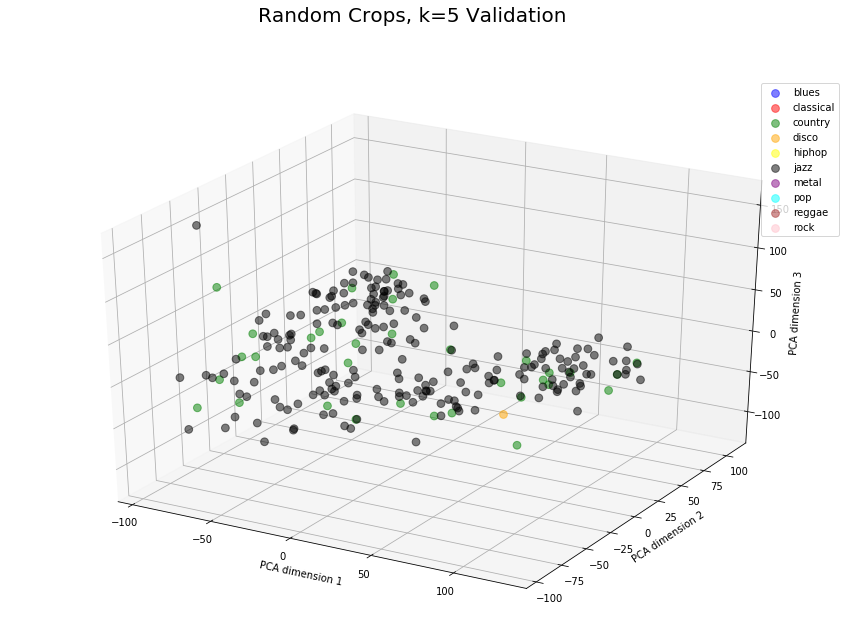

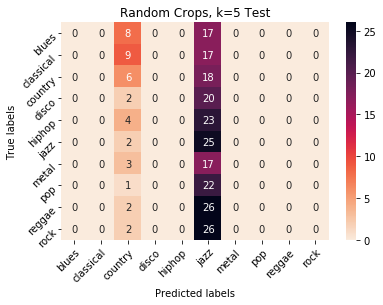

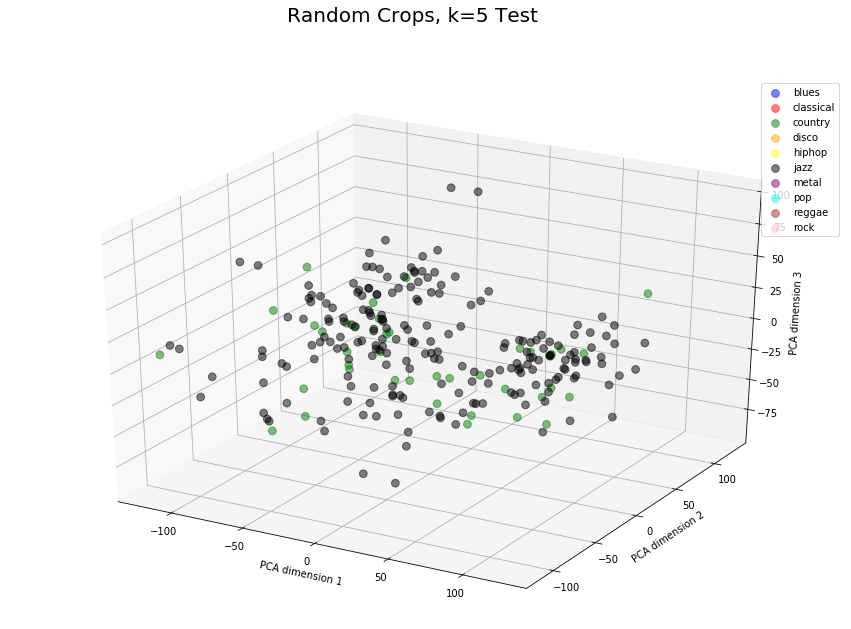

---------------------------Random Crops, k=5-------------------------------
VALIDATION: 0.1, TEST:0.088


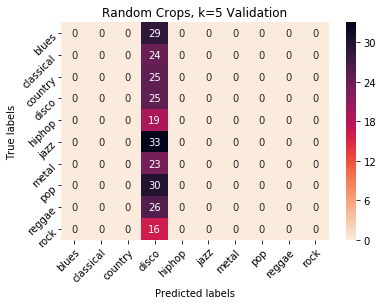

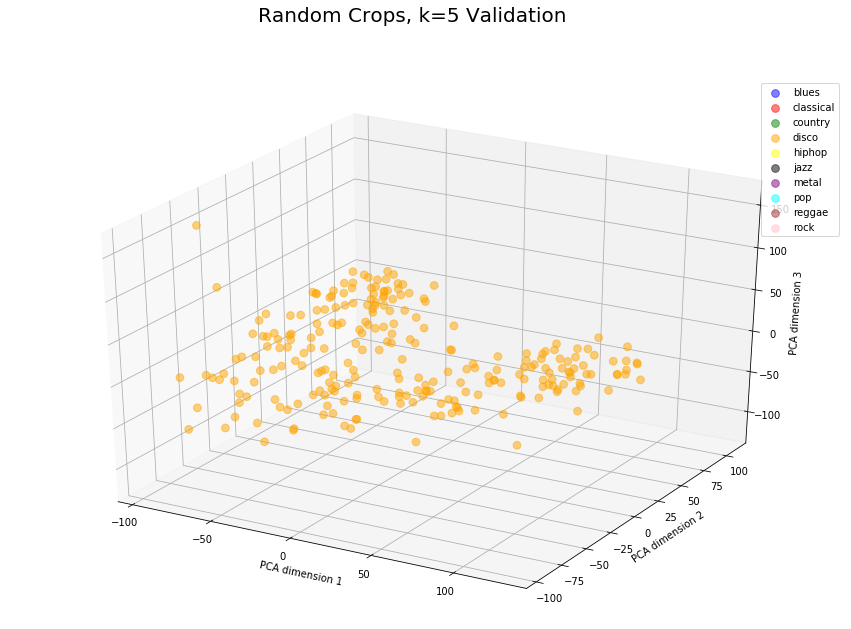

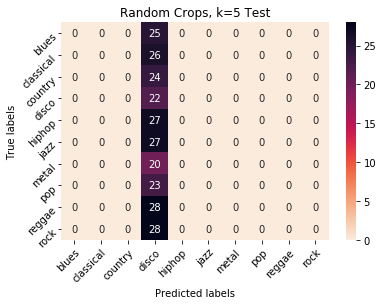

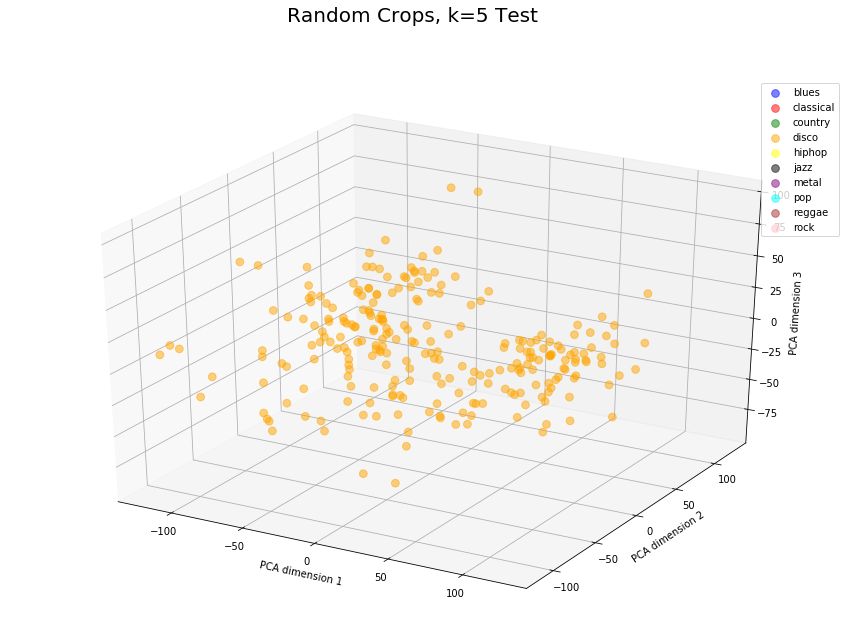

---------------------------Random Crops, k=5-------------------------------
VALIDATION: 0.092, TEST:0.08


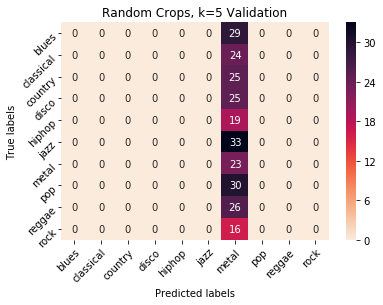

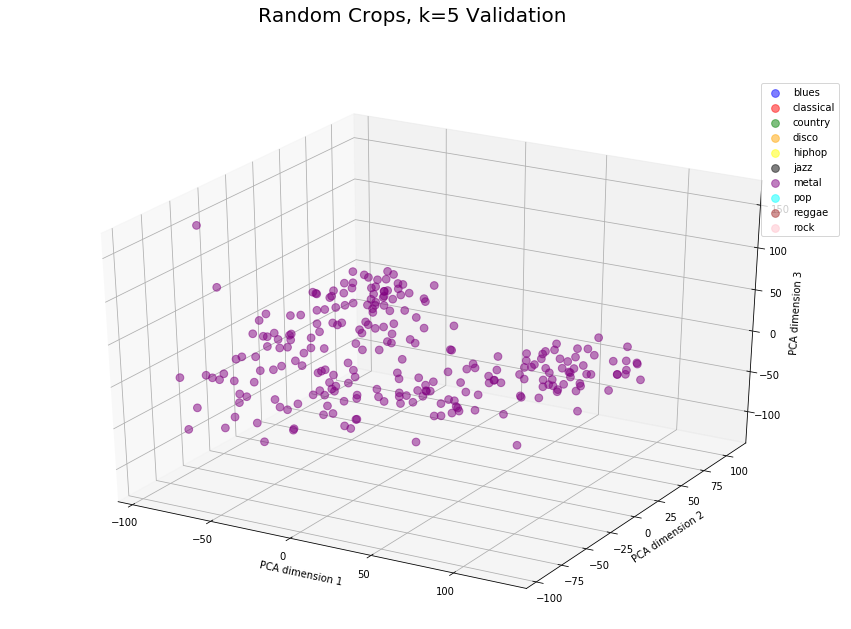

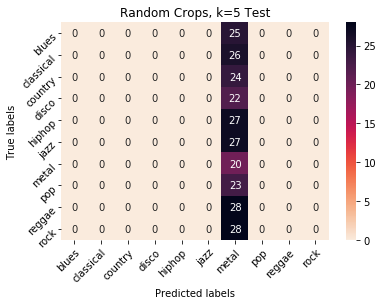

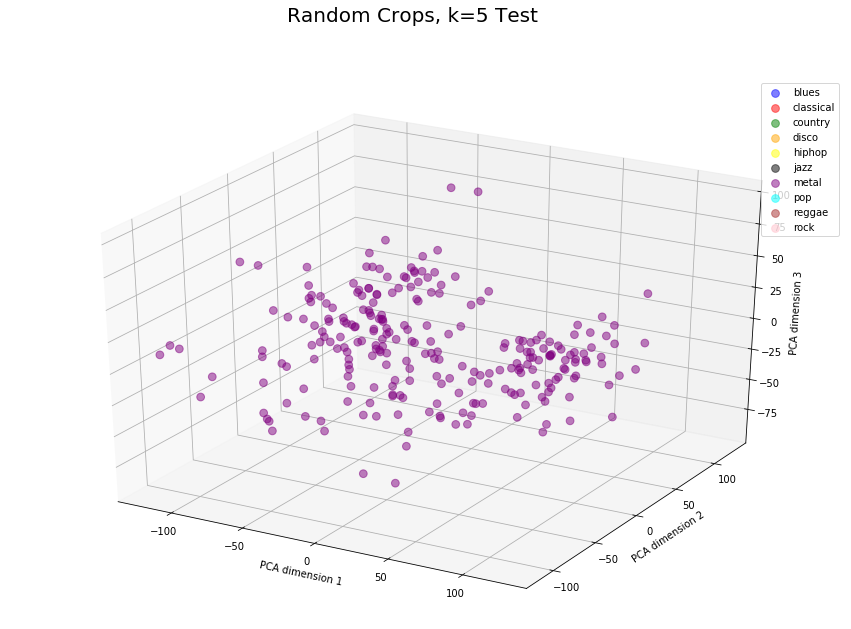

In [8]:
to_load = [
    ('nn/random_crop/val_predictions_random_crop_1.npy', 'nn/random_crop/test_predictions_random_crop_1.npy', 'Random Crops, k=1'),
    ('nn/random_crop/val_predictions_random_crop_2.npy', 'nn/random_crop/test_predictions_random_crop_2.npy', 'Random Crops, k=2'),
    ('nn/random_crop/val_predictions_random_crop_5.npy', 'nn/random_crop/test_predictions_random_crop_5.npy', 'Random Crops, k=5'),
]

for val_file, test_file, _ in to_load:
    title = 'Random Crops, k=5'
    print(f'---------------------------{title}-------------------------------')
    val_pred = np.load(val_file)
    test_pred = np.load(test_file)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Temporal Flipping

---------------------------Temporal Flipping-------------------------------
VALIDATION: 0.3, TEST:0.36


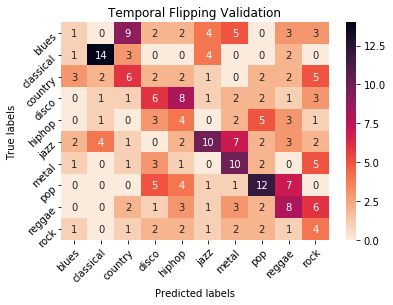

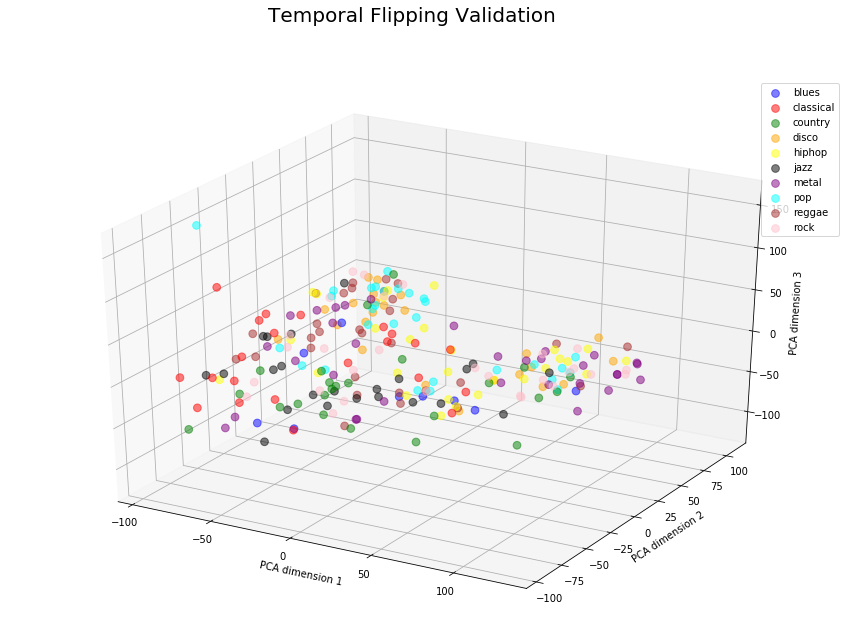

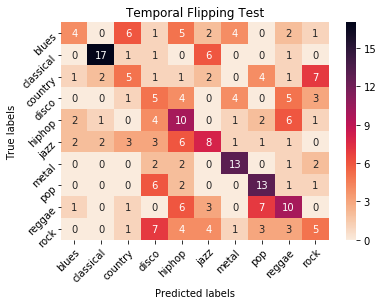

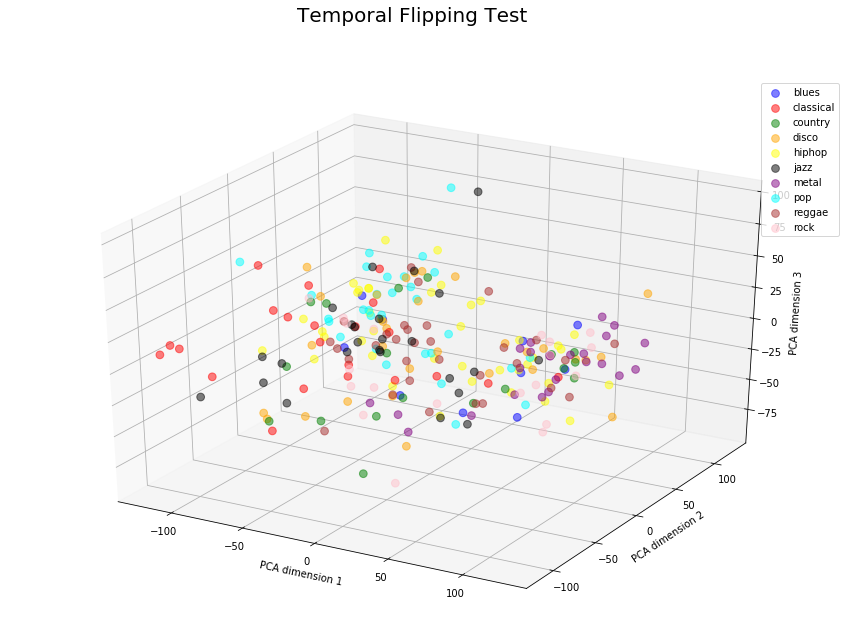

In [46]:
to_load = [
    ('nn/flipped_temp/val_predictions_vanilla_flippedtemp_sfr.npy', 'nn/flipped_temp/test_predictions_vanilla_flippedtemp_sfr.npy', 'Temporal Flipping'),
]

for val_file, test_file, title in to_load:
    print(f'---------------------------{title}-------------------------------')
    val_pred = np.load(val_file)
    test_pred = np.load(test_file)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Frequency Flipping

---------------------------Frequency Flipping-------------------------------
VALIDATION: 0.144, TEST:0.148


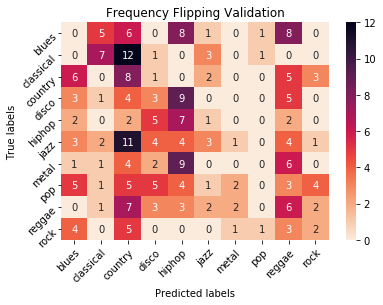

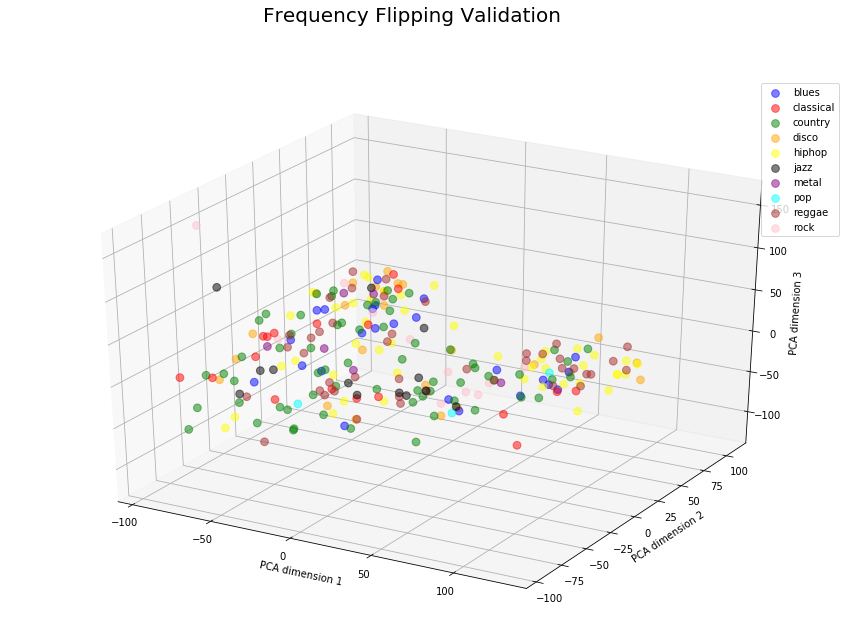

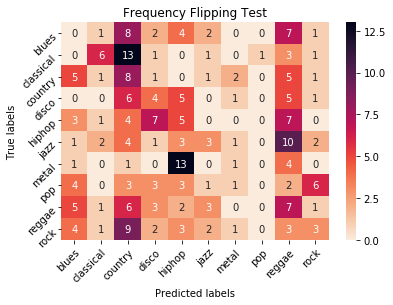

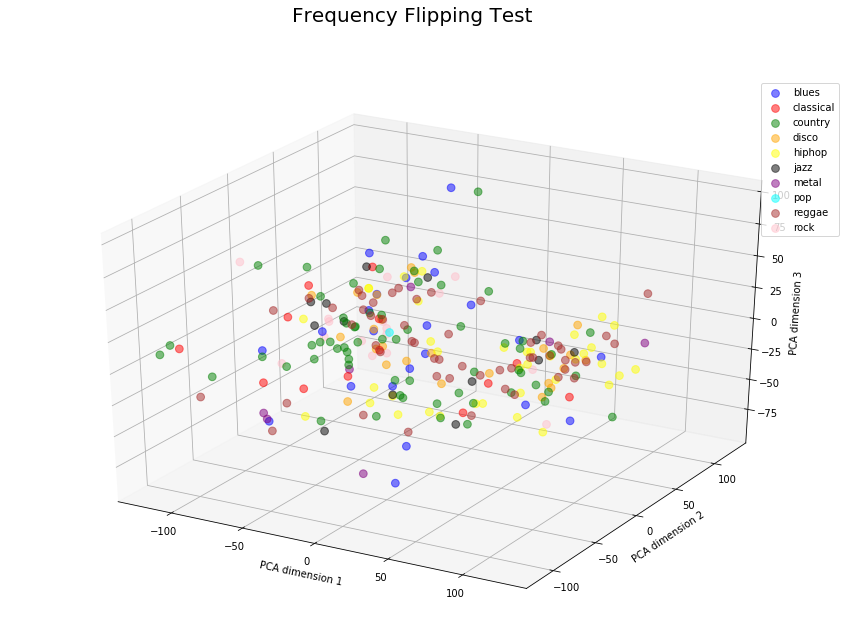

In [47]:
to_load = [
    ('nn/flipped_freq/val_predictions_vanilla_flippedfreq_sfr.npy', 'nn/flipped_freq/test_predictions_vanilla_flippedfreq_sfr.npy', 'Frequency Flipping'),
]

for val_file, test_file, title in to_load:
    print(f'---------------------------{title}-------------------------------')
    val_pred = np.load(val_file)
    test_pred = np.load(test_file)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)

## Mixup

---------------------------Mixup alpha=0.125-------------------------------
VALIDATION: 0.312, TEST:0.36


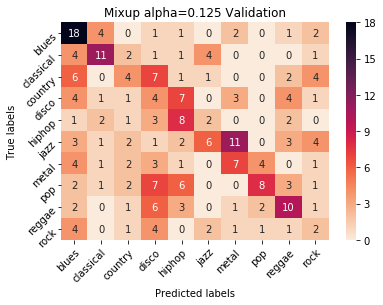

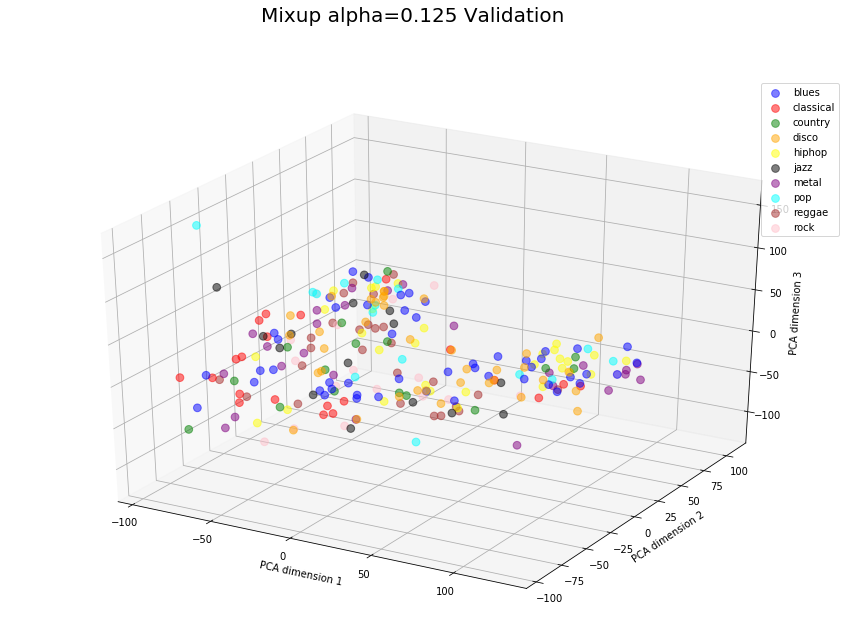

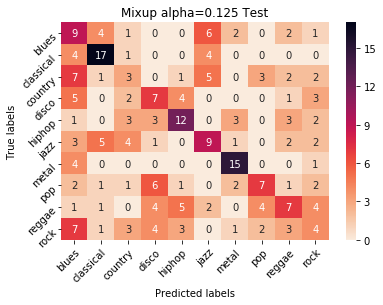

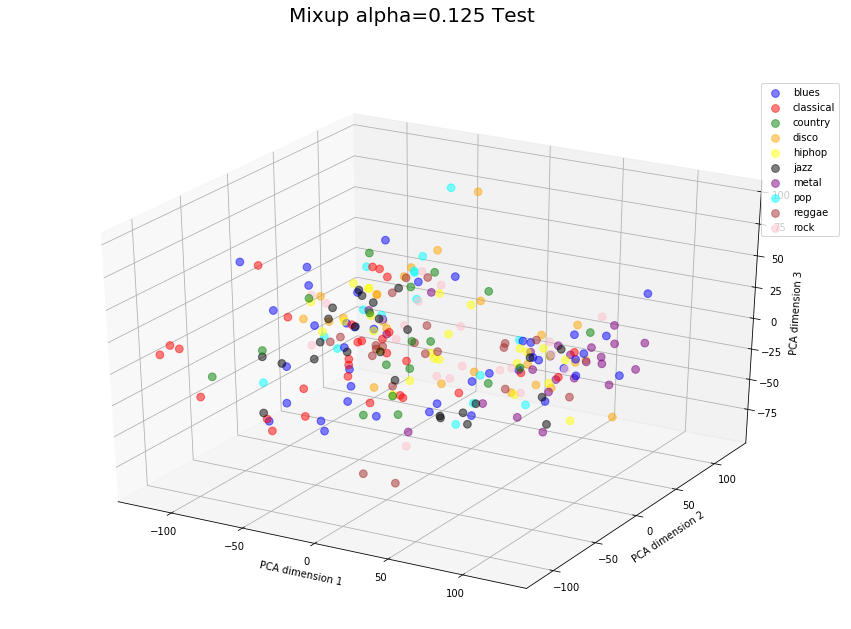

---------------------------Mixup alpha=0.25-------------------------------
VALIDATION: 0.352, TEST:0.392


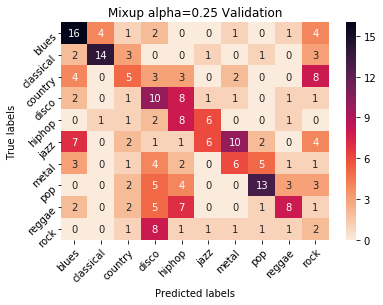

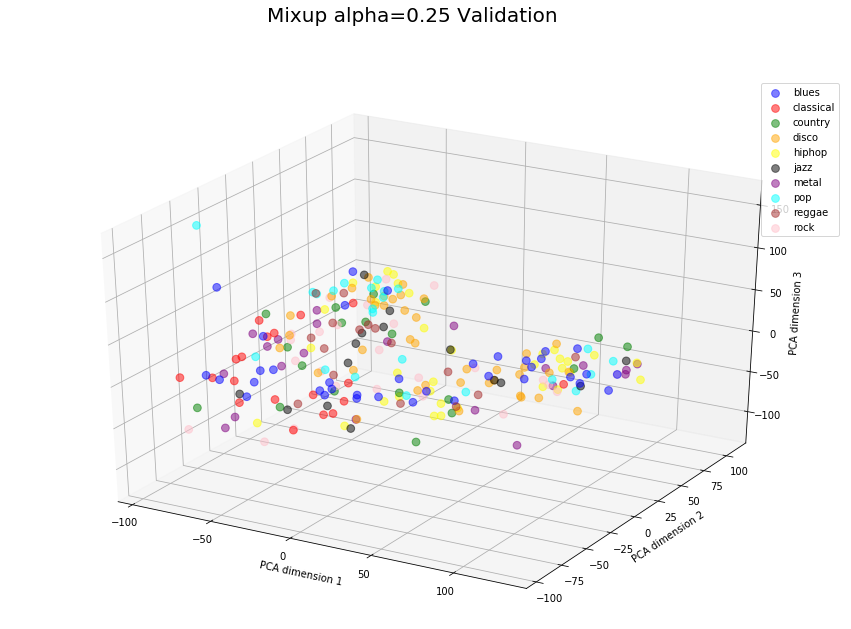

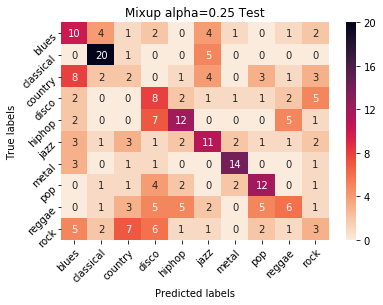

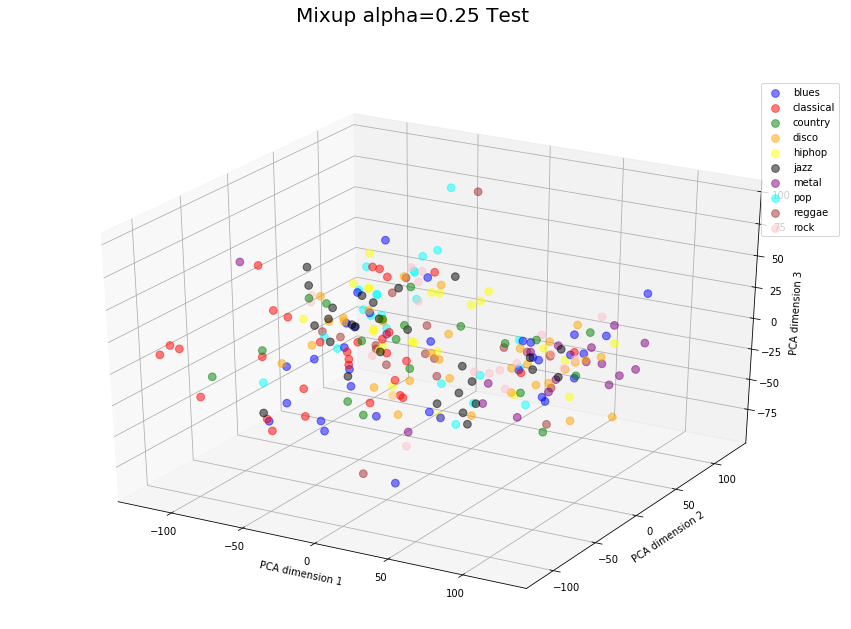

---------------------------Mixup alpha=0.5-------------------------------
VALIDATION: 0.328, TEST:0.372


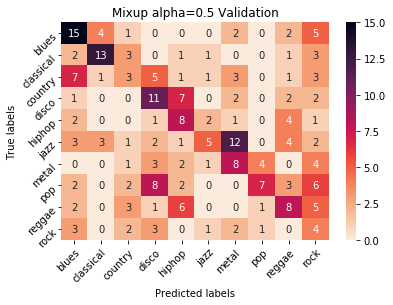

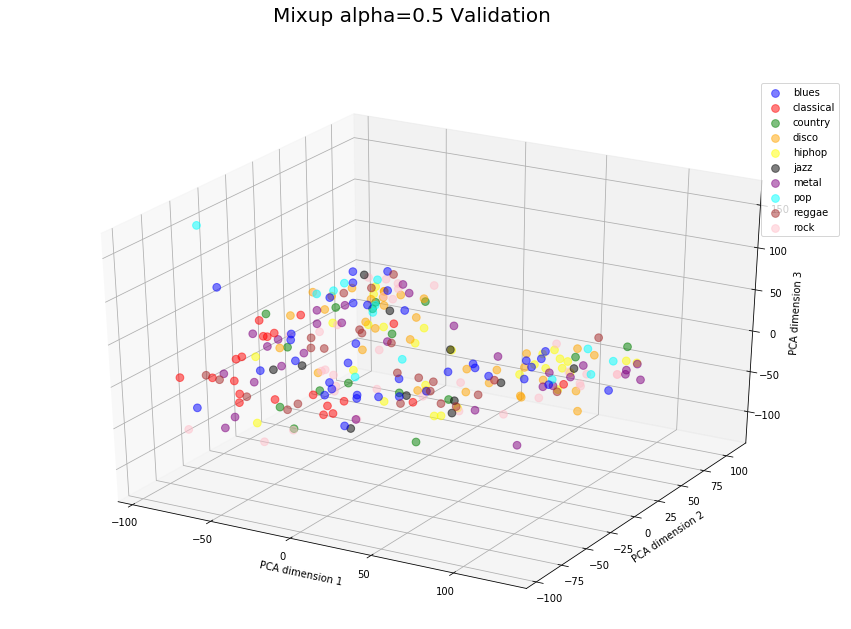

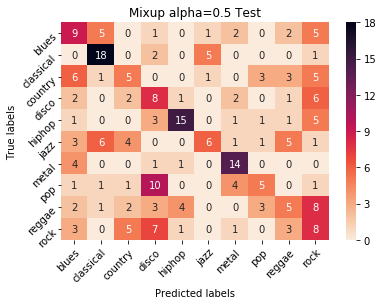

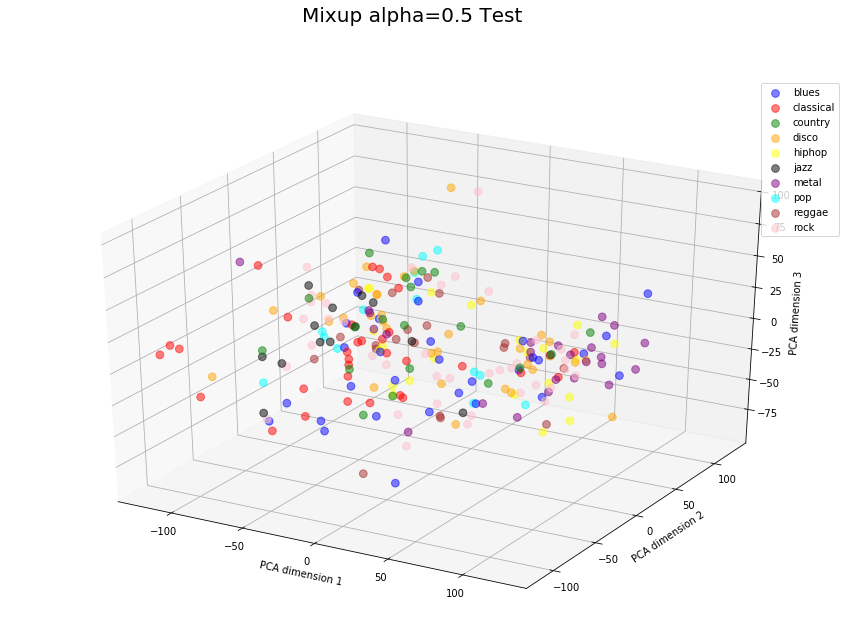

---------------------------Mixup alpha=1.0-------------------------------
VALIDATION: 0.364, TEST:0.364


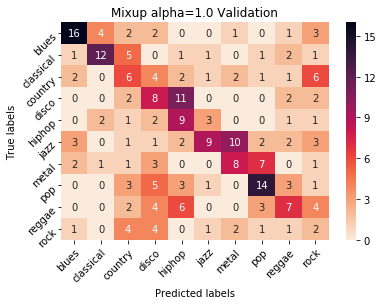

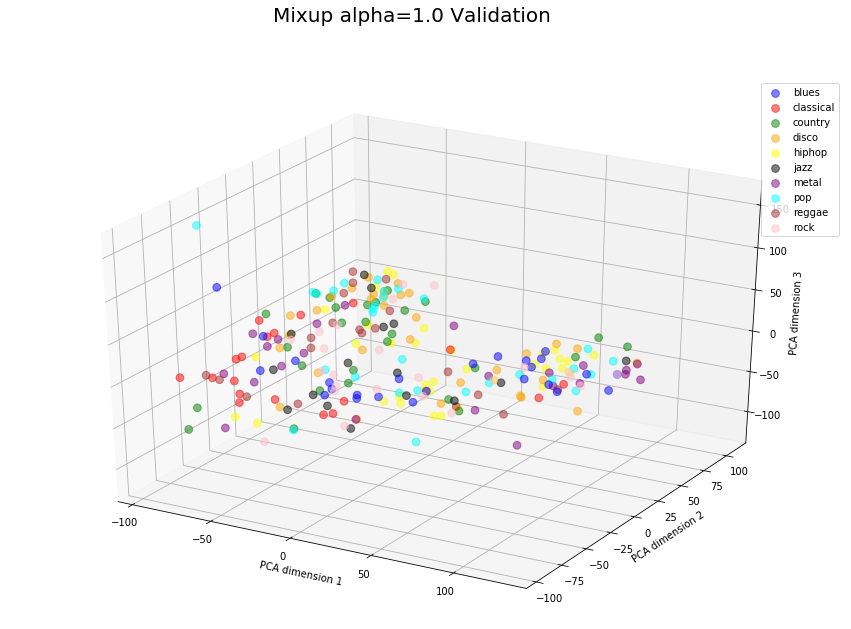

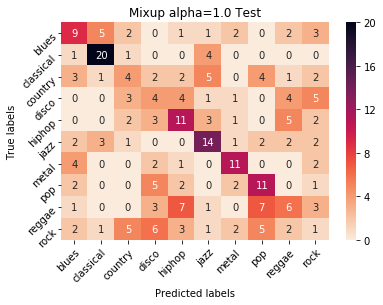

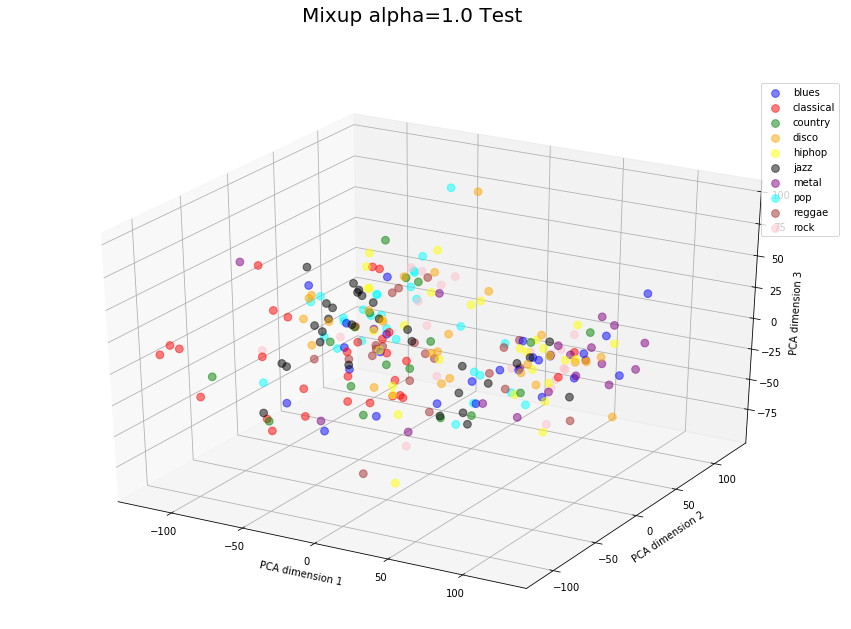

---------------------------Mixup alpha=2.0-------------------------------
VALIDATION: 0.38, TEST:0.38


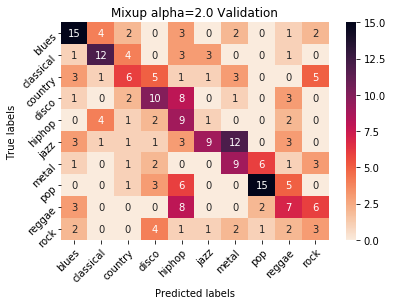

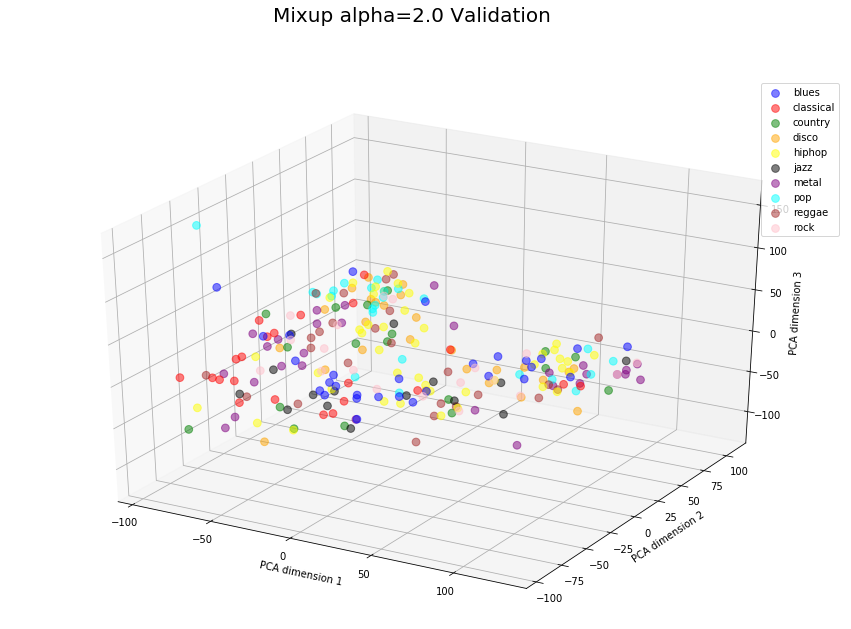

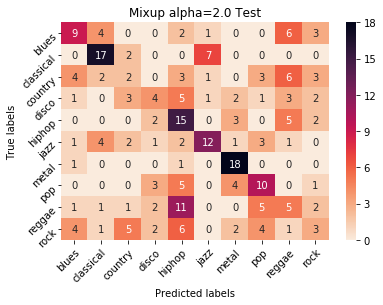

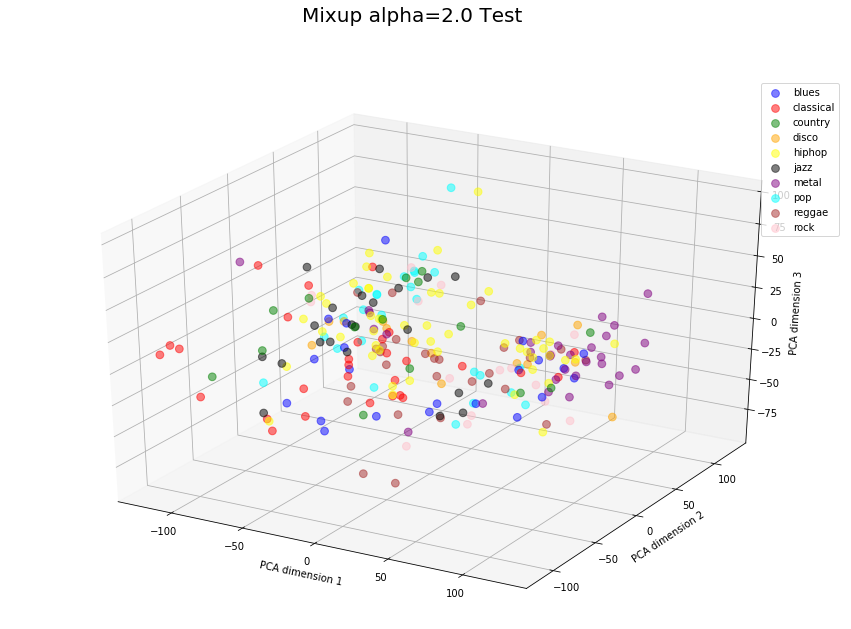

---------------------------Mixup alpha=4.0-------------------------------
VALIDATION: 0.364, TEST:0.38


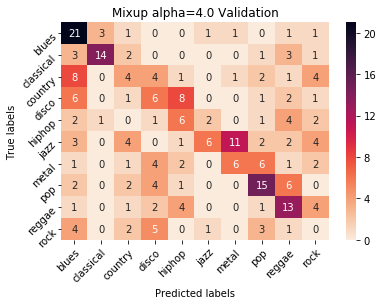

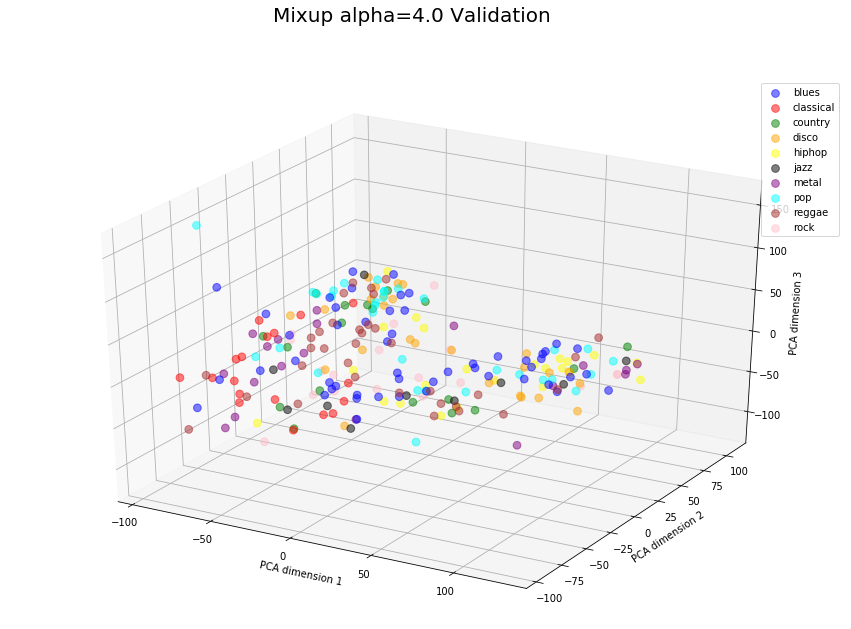

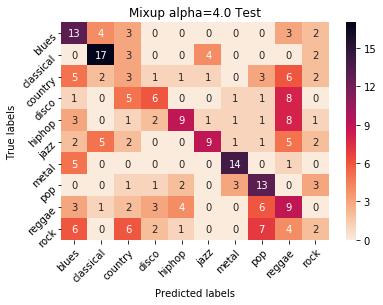

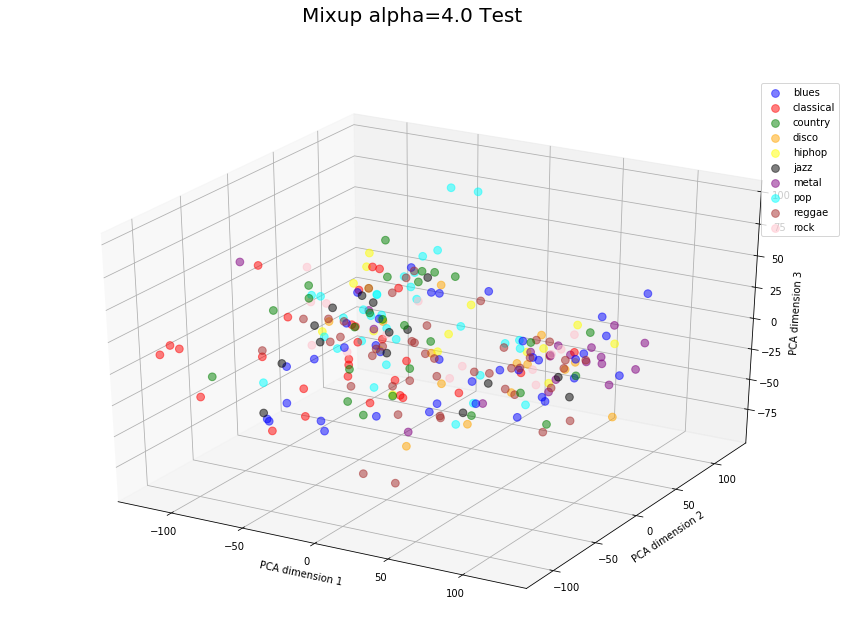

---------------------------Mixup alpha=8.0-------------------------------
VALIDATION: 0.38, TEST:0.356


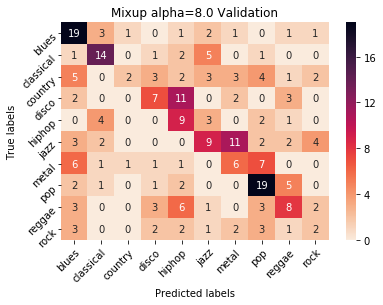

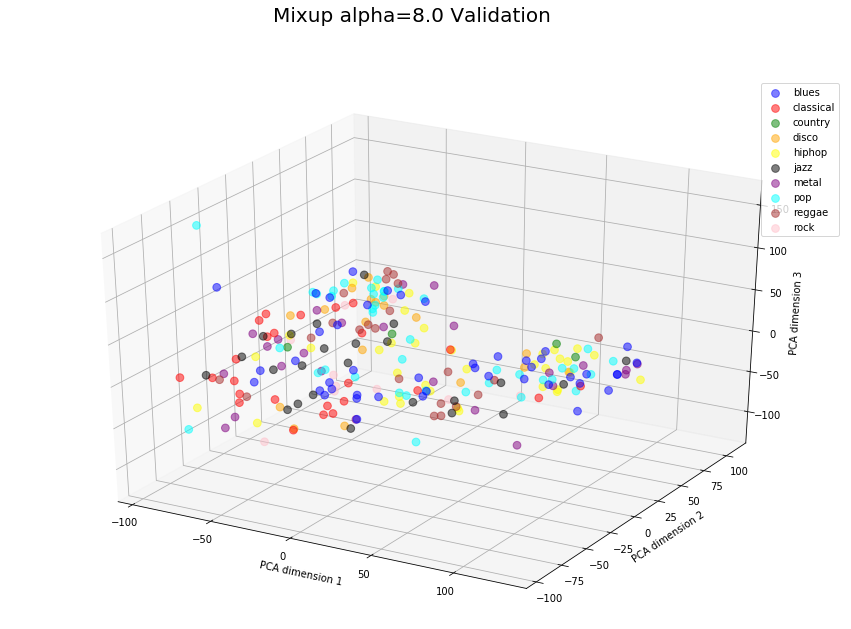

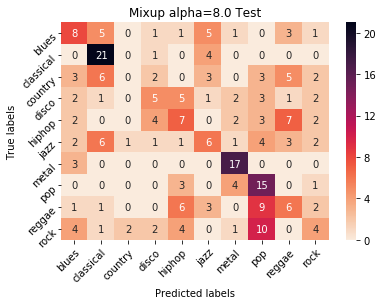

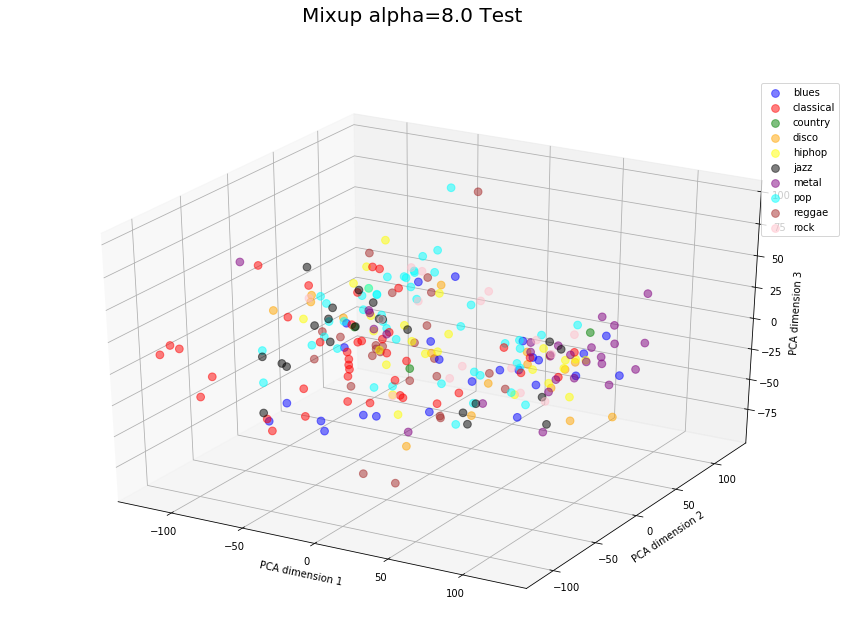

In [9]:
to_load = [
    ('nn/val_predictions_mixup0.125.npy', 'nn/test_predictions_mixup0.125.npy', 'Mixup alpha=0.125'),
    ('nn/val_predictions_mixup0.25.npy', 'nn/test_predictions_mixup0.25.npy', 'Mixup alpha=0.25'),
    ('nn/val_predictions_mixup0.5.npy', 'nn/test_predictions_mixup0.5.npy', 'Mixup alpha=0.5'),
    ('nn/val_predictions_mixup1.npy', 'nn/test_predictions_mixup1.npy', 'Mixup alpha=1.0'),
    ('nn/val_predictions_mixup2.npy', 'nn/test_predictions_mixup2.npy', 'Mixup alpha=2.0'),
    ('nn/val_predictions_mixup4.npy', 'nn/test_predictions_mixup4.npy', 'Mixup alpha=4.0'),
    ('nn/val_predictions_mixup8.npy', 'nn/test_predictions_mixup8.npy', 'Mixup alpha=8.0'),
]

for val_file, test_file, title in to_load:
    print(f'---------------------------{title}-------------------------------')
    
    val_pred = np.load(val_file)
    test_pred = np.load(test_file)
    print(f'VALIDATION: {np.sum(Y_val == val_pred)/250}, TEST:{np.sum(Y_test == test_pred)/250}')
    
    plot_confusion_matrix(Y_val, val_pred, f'{title} Validation')
    plot_labels_3d(X_val, val_pred, f'{title} Validation', X_val)
    
    plot_confusion_matrix(Y_test, test_pred, f'{title} Test')
    plot_labels_3d(X_test, test_pred, f'{title} Test', X_test)